In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, adjusted_rand_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.pipeline import Pipeline
import pprint as pp
%matplotlib inline

In [2]:
Chiller_Data = pd.read_excel('Refrigerant_Leak_Fault_Data.xlsx')
#Chiller_Data = pd.read_excel('Condenser_Fouling_Fault_Data.xlsx')

In [3]:
Chiller_Data = Chiller_Data.loc[Chiller_Data['kW'] != 1.682000e-45]
Chiller_Data.reset_index(drop=True, inplace=True)

In [4]:
Chiller_Data['Target_EPS'] = (Chiller_Data['TRC_sub'])/(Chiller_Data['TRC']-Chiller_Data['TCI'])
Chiller_Data['Target_LMTD'] = (Chiller_Data['TCO']-Chiller_Data['TCI'])/np.log((Chiller_Data['TRC']-Chiller_Data['TCI'])/(Chiller_Data['TRC']-Chiller_Data['TCO']))
Chiller_Data.dropna(axis=0,inplace=True)
TLabels = Chiller_Data['Label'].as_matrix()
X_data = Chiller_Data[['Target_EPS','Target_LMTD']].as_matrix()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


In [7]:
# Use of sklearn Pipeline
def anomalyDetector():
    t0 = time()
    np.random.seed(7)
    ########################################################################################
    # PCA and Clustering
    estimators = []
    estimators.append(('Scaler',StandardScaler()))
    #estimators.append(('PCA', PCA(n_components=2)))
    estimators.append(('Clust', AgglomerativeClustering(n_clusters=2, linkage="average", affinity="cityblock")))
    model = Pipeline(estimators)
    # pp.pprint(sorted(model.get_params().keys()))
    Labels = model.fit_predict(X_data)
    
    print("########################################################################################")
    print("Confusion Matrix - testing:")
    print(confusion_matrix(TLabels, Labels))
    tn, fp, fn, tp = confusion_matrix(TLabels, Labels).ravel()
    print("True Negative, False Positive, False Negative, True Positive {}.".format([tn, fp, fn, tp]))
    print("False positive means false alarms")
    print("False Negative means missed faults")
    print("########################################################################################")
    print("Classification Report - testing:")
    print(classification_report(TLabels, Labels, target_names=['class 0', 'class 1']))
    print("########################################################################################")
    print("Accuracy - testing: %0.3f" % accuracy_score(TLabels, Labels))
    print("########################################################################################")
    print("ROC AUC score - testing: %0.3f" % roc_auc_score(TLabels, Labels))
    print("########################################################################################")
    ########################################################################################
    
    
    fig = plt.figure(figsize=(25,10))
    ax = fig.add_subplot(1, 1, 1)
    Temp = pd.DataFrame(data={'Component1': X_data[:,0], 'Component2': X_data[:,1], 
                              'TrueLabels': TLabels, 'PredLabels':Labels})
    #unique_labels = Temp['TrueLabels'].unique()
    #print(unique_labels)
    #cols = [plt.cm.coolwarm(each) for each in np.linspace(0, 1, len(unique_labels))]
    #colors = dict(zip(unique_labels, cols))
    #ax.scatter(Temp['Component1'], Temp['Component2'], c=Temp['TrueLabels'].map(lambda x: colors[x]),
    #         s=200)
    
    Data_0 = Temp.loc[Temp['TrueLabels'][Temp['TrueLabels']==0].index]
    Data_1 = Temp.loc[Temp['TrueLabels'][Temp['TrueLabels']==1].index]
    ax.scatter(Data_0['Component1'], Data_0['Component2'], c='b', s=400,
               edgecolors='k', marker='o', label=u'Normal data',alpha=.9)
    ax.scatter(Data_1['Component1'], Data_1['Component2'], c='r', s=200, 
               edgecolors='k', marker='o', label=u'Faulty data',alpha=.6)
    plt.legend(loc='upper left',fontsize=30)
    plt.xlabel('$\epsilon_{sc}$',fontsize=40)
    plt.ylabel('$LMTD_{cd}$',fontsize=40)
    #plt.title('True Labels',fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.savefig('Cluster-Visualization-Refrigerant-Leakage')
    
    fig = plt.figure(figsize=(25,10))
    ax = fig.add_subplot(1, 1, 1)
    unique_labels = Temp['PredLabels'].unique()
    print(unique_labels)
    cols = [plt.cm.coolwarm(each) for each in np.linspace(0, 1, len(unique_labels))]
    colors = dict(zip(unique_labels, cols))
    ax.scatter(Temp['Component1'], Temp['Component2'], c=Temp['PredLabels'].map(lambda x: colors[x]),
             s=200)
    plt.xlabel('$\epsilon_{sc}$',fontsize=40)
    plt.ylabel('$LMTD_{cd}$',fontsize=40)
    #plt.title('Predicted Labels',fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.show()
    #########################################################################################

########################################################################################
Confusion Matrix - testing:
[[424   1]
 [421   1]]
True Negative, False Positive, False Negative, True Positive [424, 1, 421, 1].
False positive means false alarms
False Negative means missed faults
########################################################################################
Classification Report - testing:
             precision    recall  f1-score   support

    class 0       0.50      1.00      0.67       425
    class 1       0.50      0.00      0.00       422

avg / total       0.50      0.50      0.34       847

########################################################################################
Accuracy - testing: 0.502
########################################################################################
ROC AUC score - testing: 0.500
########################################################################################
[1 0]


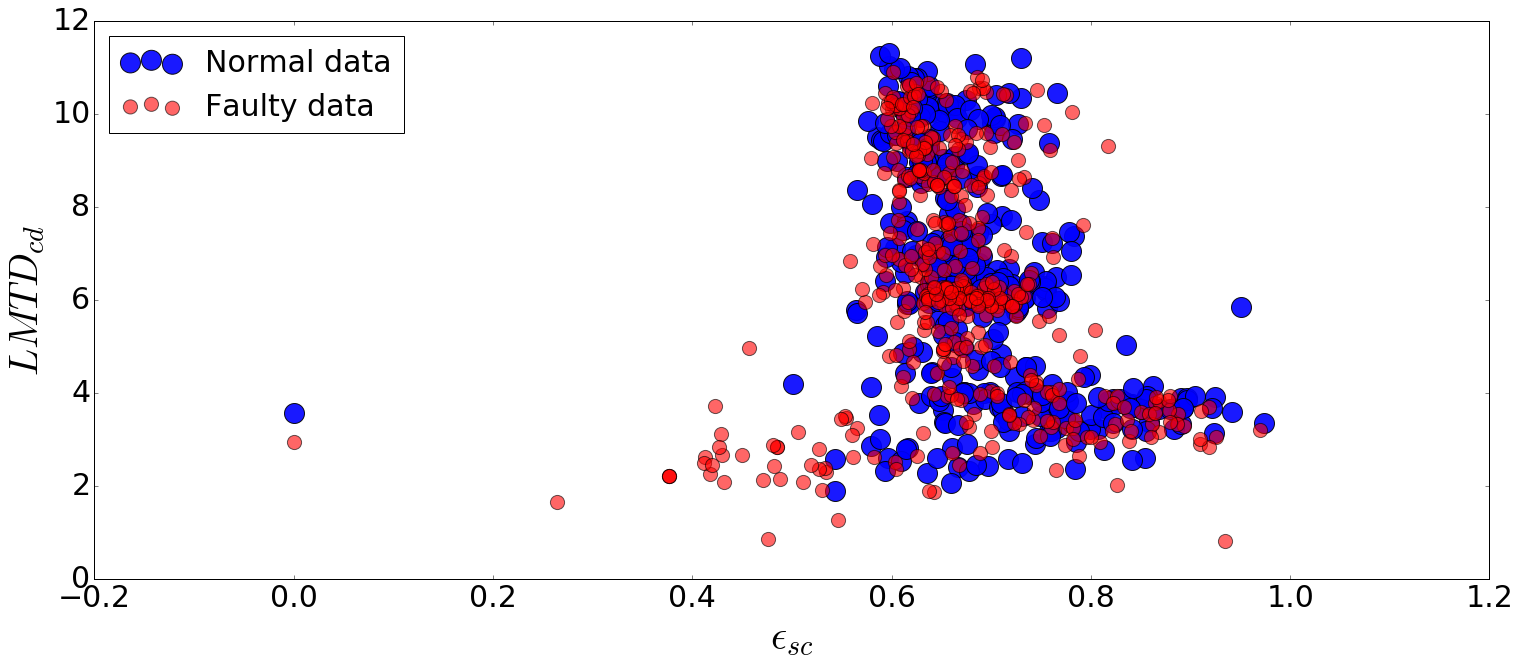

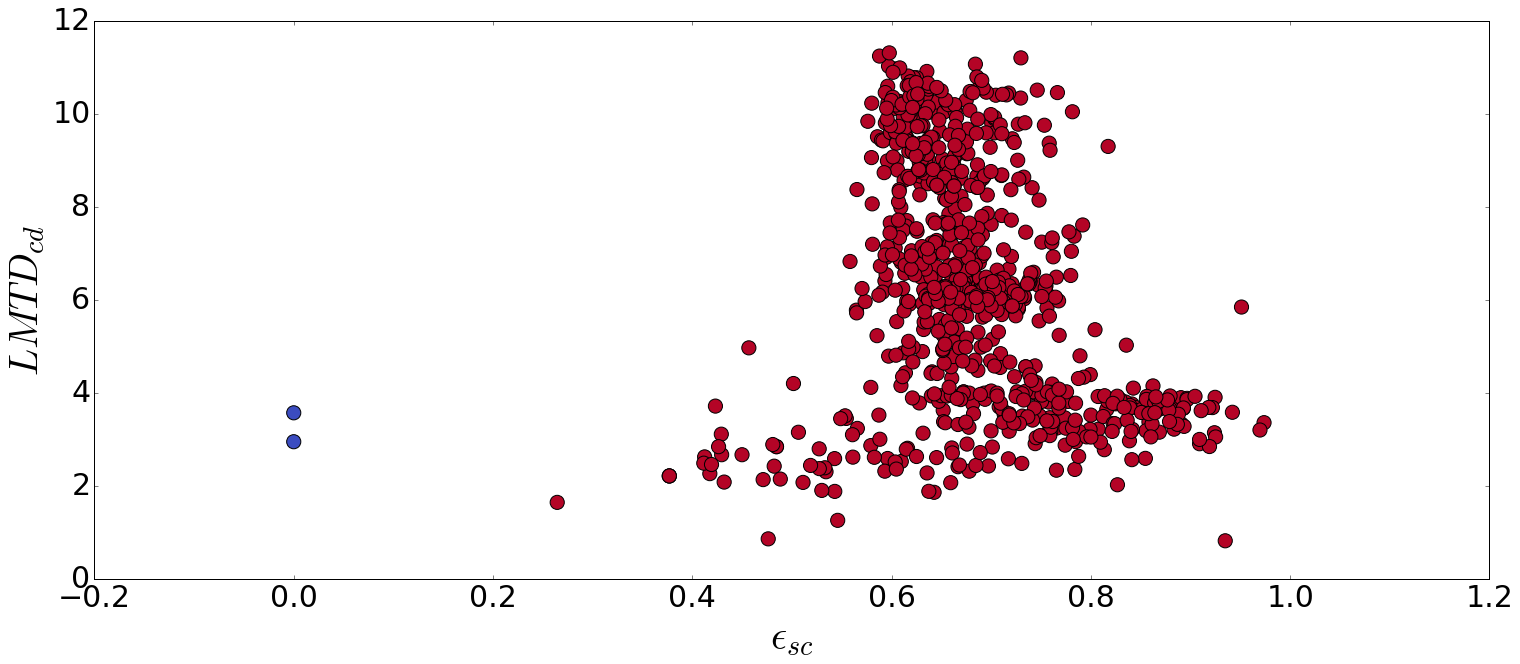

In [8]:
anomalyDetector()